In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
import xgboost as xgb

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import validation_curve
from sklearn.model_selection  import StratifiedKFold
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.metrics import accuracy_score, roc_curve, auc

from IPython.display import Latex

/home/mlepicka/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mlepicka/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mlepicka/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mlepicka/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mlepicka/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mlepicka/anaconda3/lib/python

# Step 1

After importing neeeded libraries, we begin with feature enginnering.

In [2]:
df1 = pd.DataFrame(pd.read_csv('train.csv')) # insert path to csv files here
df2 = pd.DataFrame(pd.read_csv('test.csv'))

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)

df = [df1, df2]

for i in range(0, len(df)):
    df[i]['Sex'] = df[i]['Sex'].map({'female': 1, 'male': 0})
    df[i]['Embarked'] = df[i]['Embarked'].map({'Q': 1, 'C': 0, 'S': 2})
    df[i]["Age"] = imp.fit_transform(df[i][["Age"]]).ravel()
    df[i]['Embarked'] = imp.fit_transform(df[i][['Embarked']]).ravel()
    df[i].Embarked = df[i].Embarked.astype(int)
    df[i].Age = df[i].Age.astype(int)
    df[i]['FamilySize'] = df[i]['SibSp'] + df[i]['Parch'] + 1
    df[i] = df[i].assign(FamilySize = pd.Series(df[i]['FamilySize']))
    df[i]['HasCabin'] = df[i]['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
#     df['Name_length'] = df['Name'].apply(len)
#     df['IsAlone'] = 0
#     df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
    df[i]['Single'] = df[i]['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df[i]['SmallF'] = df[i]['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
    df[i]['MedF'] = df[i]['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    df[i]['LargeF'] = df[i]['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
    df[i]['Title'] = df[i]['Name'].apply(get_title)
    df[i]['Title'] = df[i]['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df[i]['Title'] = df[i]['Title'].replace('Mlle', 'Miss')
    df[i]['Title'] = df[i]['Title'].replace('Ms', 'Miss')
    df[i]['Title'] = df[i]['Title'].replace('Mme', 'Mrs')
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df[i]['Title'] = df[i]['Title'].map(title_mapping)
    df[i]['Title'] = df[i]['Title'].fillna(0)

    #df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin'] ])
    #df['Cabin'] = df['Cabin'].map({'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'T': 1})
    
df1 = df[0]
df2 = df[1]
df1 = df1.drop(columns = ['PassengerId', 'Name', 'Cabin', 'Ticket', 'Fare', 'Age']) # 'Name_length',
df2 = df2.drop(columns = ['Name', 'Cabin', 'Ticket', 'Fare',  'Age']) #'Name_length',

# Step 2

We train our models:

1. LightGBM
2. XGBoost
3. Linear Regression

In [3]:
def perform_repeated_cv(X, y):
    #set the number of repetitions
    n_reps = 50

    for u in range(n_reps):
        #initialize vector to keep predictions from all folds of the cross-validation
        y_predict_lgb = np.zeros(y.shape)
        y_predict_xgb = np.zeros(y.shape)
        y_predict_reg = np.zeros(y.shape)

        skf = StratifiedKFold(n_splits = 5, random_state = 142)
        for train, test in skf.split(X, y):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]

            #standardization
            sc = StandardScaler().fit(X_train)
            X_train = sc.transform(X_train)
            X_test = sc.transform(X_test)
            
        #============================================================================
        # LGBM    
        
            d_train = lgb.Dataset(X_train, label = y_train)
            
            params = {'boosting_type': 'gbdt',
                     'max_depth': -1,
                     'objective': 'binary',
                     'nthread': 3,
                     'num_leaves': 6,
                     'learning_rate': 0.1,
                     'max_bin': 512,
                     'subsample_for_bin': 200,
                     'subsample': 1,
                     'subsample_freq': 1,
                     'colsample_bytree': 0.6,
                     'reg_alpha': 0.5,
                     'reg_lambda': 4,
                     'min_split_gain': 0.5,
                     'min_child_weight': 1,
                     'min_child_samples': 5,
                     'scale_pos_weight': 1,
                     'num_class': 1,
                     'metric': 'auc'}
            
            modellgb = lgb.train(params, d_train, 100)
            y_predict_lgb[test] = modellgb.predict(X_test) 

        #============================================================================            
        # XGB  
        
            xgtrain = xgb.DMatrix(X_train, y_train.values)
            xgtest = xgb.DMatrix(X_test)

            param = {'max_depth': 10, 
                     'min_child_weigth': 3, 
                     'eta': 0.02, 
                     'silent': 1,
                     'eval_metric': 'auc',
                     'seed': 1001,
                     'colsample_bytree': 0.9,
                     'subsample': 0.9,
                     'gamma': 0.0964,
                     'objective':'binary:logistic', 
                     'lambda': 2,
                     'alpha': 0.03}
            
            num_round = 150
            modelxgb = xgb.train(param, xgtrain, num_round)
            y_predict_xgb[test] = modelxgb.predict(xgtest)
            
        #============================================================================
        # LREG
        
            lm = linear_model.LinearRegression()
            modelreg = lm.fit(X_train, y_train)
            y_predict_reg[test]  = modelreg.predict(X_test)
            
        #============================================================================
        
    for i in range(0, len(y_predict_lgb)):
        y_predict_lgb[i] = (y_predict_lgb[i] - y_predict_lgb.min()) / (y_predict_lgb.max() - y_predict_lgb.min())
    
    for i in range(0, len(y_predict_reg)):
        y_predict_reg[i] = (y_predict_reg[i] - y_predict_reg.min()) / (y_predict_reg.max() - y_predict_reg.min())
    
    for i in range(0, len(y_predict_xgb)):
        y_predict_xgb[i] = (y_predict_xgb[i] - y_predict_xgb.min()) / (y_predict_xgb.max() - y_predict_xgb.min()) 
        
    #============================================================================
    
    return y_predict_lgb, y_predict_xgb, y_predict_reg, modelreg, modelxgb, modellgb

In [4]:
X = df1.drop(columns = ['Survived'])
y = df1['Survived']

y_predict_lgb, y_predict_xgb, y_predict_reg, modelreg, modelxgb, modellgb = perform_repeated_cv(X, y)

# Step 3 (Optional)

We create ROC AUC curves to check how our trained models perform. Other metrics like accuracy_score can also be used.

In [5]:
def create_roc_auc_curve(actual, predictions):

    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f'% roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

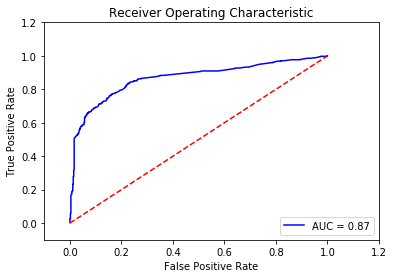

In [6]:
#============================================================================
# XGB
create_roc_auc_curve(y, y_predict_xgb)

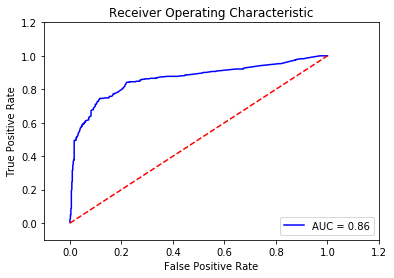

In [7]:
#============================================================================
# LGBM
create_roc_auc_curve(y, y_predict_lgb)

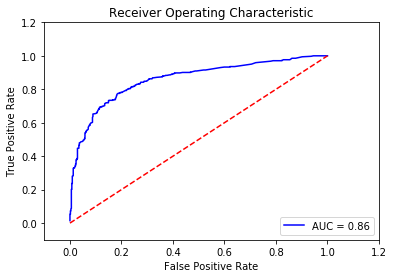

In [8]:
#============================================================================
# REG

create_roc_auc_curve(y, y_predict_reg) 


# Step 4

We create predictions using our trained models.

In [10]:
Xt = df2.drop(columns = ['PassengerId'])
yt = df2['PassengerId']

sc = StandardScaler()
Xt_test = sc.fit_transform(Xt)
xgt_test = xgb.DMatrix(Xt_test)

yt_predict_reg = modelreg.predict(Xt_test) # reg

yt_predict_xgb = modelxgb.predict(xgt_test) # xgb 

yt_predict_lgb = modellgb.predict(Xt_test) #lgbm 

for i in range(0, len(yt_predict_lgb)):
    yt_predict_lgb[i] = (yt_predict_lgb[i] - yt_predict_lgb.min()) / (yt_predict_lgb.max() - yt_predict_lgb.min())
    
for i in range(0, len(yt_predict_reg)):
    yt_predict_reg[i] = (yt_predict_reg[i] - yt_predict_reg.min()) / (yt_predict_reg.max() - yt_predict_reg.min())
    
for i in range(0, len(yt_predict_xgb)):
    yt_predict_xgb[i] = (yt_predict_xgb[i] - yt_predict_xgb.min()) / (yt_predict_xgb.max() - yt_predict_xgb.min())

# Step 5

We add predicted scores to the DataFrames used for training and testing. 

In [11]:
M_features = pd.DataFrame({'M_lgbm': y_predict_lgb, 'M_xgb': y_predict_xgb, 'M_reg': y_predict_reg})
Mt_features = pd.DataFrame({'Mt_lgbm': yt_predict_lgb, 'Mt_xgb': yt_predict_xgb, 'Mt_reg': yt_predict_reg})

df1 = df1.assign(M_lgbm = pd.Series(M_features['M_lgbm']), M_xgb = pd.Series(M_features['M_xgb']), M_reg = pd.Series(M_features['M_reg']))
df2 = df2.assign(Mt_lgbm = pd.Series(Mt_features['Mt_lgbm']), Mt_xgb = pd.Series(Mt_features['Mt_xgb']), Mt_reg = pd.Series(Mt_features['Mt_reg']))

# Step 6

We repeat previous steps, but this time we are using the Random Forest Classifier with our updated training and testing sets.

In [12]:
def perform_repeated_cv_with_M_features(X, y):
    #set the number of repetitions
    n_reps = 50

    for u in range(n_reps):
        #initialize vector to keep predictions from all folds of the cross-validation
        y_predict_rf = np.zeros(y.shape)

        #perform 10-fold cross validation
        skf = StratifiedKFold(n_splits = 5, random_state = 142)

        for train, test in skf.split(X, y):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]

            #standardization
            sc = StandardScaler().fit(X_train)
            X_train = sc.transform(X_train)
            X_test = sc.transform(X_test)
            
        #============================================================================
        # RF
            rf = RandomForestRegressor(n_estimators = 147, 
                           max_features = 0.1171,
                           max_depth = 9, 
                           min_samples_split = 12,
                           min_samples_leaf = 8,
                           bootstrap = True,
                           max_leaf_nodes = 25,
                           min_weight_fraction_leaf = 0.2,
                           random_state = 250) 

            modelrf = rf.fit(X_train, y_train)
            y_predict_rf[test] = modelrf.predict(X_test)
            
        #============================================================================
        
#     for i in range(0, len(y_predict_rf)):
#         y_predict_rf[i] = (y_predict_rf[i] - y_predict_rf.min()) / (y_predict_rf.max() - y_predict_rf.min())
        
    return y_predict_rf, modelrf

In [ ]:
Xrf = df1.drop(columns = ['Survived'])
yrf = df1['Survived']

y_predict_rf, modelrf = perform_repeated_cv_with_M_features(Xrf, yrf)

In [ ]:
create_roc_auc_curve(yrf, y_predict_rf)

In [13]:
Xtrf = df2.drop(columns = ['PassengerId']) 
ytrf = df2['PassengerId']

ytrf = ytrf.reset_index(drop=True)
ytrf = pd.DataFrame(np.array(ytrf).reshape(len(ytrf)), columns = ['PassengerId'])

Xtrf = pd.DataFrame(Xtrf)
yt_predict_rf = modelrf.predict(Xtrf)

# for i in range(0, len(yt_predict_rf)):
#     yt_predict_rf[i] = (yt_predict_rf[i] - yt_predict_rf.min()) / (yt_predict_rf.max() - yt_predict_rf.min())

In [14]:
df_pred_rf = pd.DataFrame({'SurvivalPred': yt_predict_rf})
df_pred_rf['SurvivalPred'].value_counts()

0.336799    138
0.553739     25
0.345516     20
0.405423     19
0.506807     19
0.461694     18
0.545976     16
0.554151     14
0.341223     14
0.546387     11
0.337330     10
0.515857      7
0.446776      6
0.532693      5
0.428662      5
0.357975      4
0.502575      4
0.345523      4
0.468909      4
0.392738      3
0.528439      3
0.410130      3
0.353279      3
0.383220      2
0.418436      2
0.358375      2
0.519540      2
0.537337      2
0.511365      2
0.349658      2
           ... 
0.419292      2
0.405741      1
0.441058      1
0.464600      1
0.500687      1
0.409835      1
0.435998      1
0.467806      1
0.492864      1
0.353551      1
0.545100      1
0.507219      1
0.451057      1
0.349825      1
0.387983      1
0.420060      1
0.366577      1
0.453455      1
0.549246      1
0.423536      1
0.466468      1
0.542133      1
0.423954      1
0.532671      1
0.396585      1
0.515224      1
0.483632      1
0.484101      1
0.505321      1
0.493563      1
Name: SurvivalPred, Leng

# Step 7

Scatter plots help us to determine the probabilty treshold to turn our probabilities into 0 and 1 values.

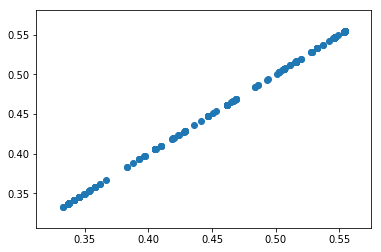

In [15]:
plt.scatter(df_pred_rf, df_pred_rf)

In [16]:
ytrf = ytrf.assign(Survived = pd.Series())

for i in range(0, 418):
    
    if(df_pred_rf['SurvivalPred'][i] > 0.46):
        ytrf['Survived'][i] = 1
    if(df_pred_rf['SurvivalPred'][i] <= 0.46):
        ytrf['Survived'][i] = 0

/home/fschmidt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/fschmidt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Step 8 (Optional)

After I have submitted a csv file to kaggle with only 0 values, my submissions scored 0.62679. I use the cell below to check how many 0 values I have in my submission file. If the cell outputs a value not in the 60-70% range, I can tell that something is wrong.

In [17]:
deathavgrf = (1 - sum(ytrf['Survived']) / 418) * 100

print('[STACKING-rf]: ', deathavgrf, '% of passengers found dead.')

[STACKING-rf]:  62.91866028708134 % of passengers found dead.


# Step 9

Let's just save the file and submit it to kaggle.

In [18]:
ytrf['Survived'] = ytrf['Survived'].astype(int)
ytrf.to_csv('score-stack-rf-079425.csv', index = False)